In [2]:
!pip install monai
!pip3 install nibabel
!pip3 install torch
!pip3 install sklearn
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your depende

In [19]:
import os
import shutil
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.inferers import SliceInferer
from monai.networks.nets import UNet
from tqdm import tqdm
from monai.transforms import LoadImage, LoadImaged, Resized, Compose, SaveImage
#print_config()

In [20]:
#T1 dataset :https://brain-development.org/ixi-dataset/
# Define your NIfTI image directory
image_dir = "/home/sayadkouhs/Desktop/dataset/IXI-T1"
print(image_dir)


/home/sayadkouhs/Desktop/dataset/IXI-T1


In [21]:
# Load each image separately and store it in a list
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")
images = []
#for path in image_paths:
#    img = LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True)(path)
#    images.append(img)
#nibabelreader used for the .nii.gz images.

Total NIfTI files found: 581


In [22]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import torch
from monai.transforms import LoadImage, EnsureChannelFirst, Compose, ToTensor
from monai.networks.nets import UNet
from monai.inferers import SliceInferer
import numpy as np
import sys
print(sys.version, sys.platform, sys.executable)
from tqdm import tqdm

transform = Compose([
    LoadImage(image_only=True, reader="NibabelReader",squeeze_non_spatial_dims=True),
    EnsureChannelFirst()
    # squeeze here, outside
])
input_volume = transform(image_paths[100])  # Shape: (1, D, H, W)


# Ensure the input volume has the shape (N, C, D, H, W)
input_volume = input_volume.unsqueeze(0)  # Add batch dimension, shape: (1, 1, D, H, W)

# Define a 2D U-Net with randomly initialized weights for testing purposes
net = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2,
)

# Perform inference along the axial plane (D axis)
axial_inferer = SliceInferer(roi_size=(256, 256), sw_batch_size=1, cval=-1, progress=True)

# Infer along axial slices
axial_output = axial_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Axial Inferer Output Shape: ", axial_output.shape)

# Perform inference along the coronal plane (H axis)
coronal_inferer = SliceInferer(
    roi_size=(64, 256),  # ROI size for slicing along the H axis
    sw_batch_size=1,
    spatial_dim=1,  # Slice along H axis
    cval=-1,
    progress=True,
)

# Infer along coronal slices
coronal_output = coronal_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Coronal Inferer Output Shape: ", coronal_output.shape)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] linux /bin/python3


100%|██████████| 256/256 [00:01<00:00, 186.23it/s]


Axial Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


100%|██████████| 1280/1280 [00:03<00:00, 347.12it/s]


Coronal Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


Axial slice shape : (256, 150) Coronal slice shape:  (256, 150)


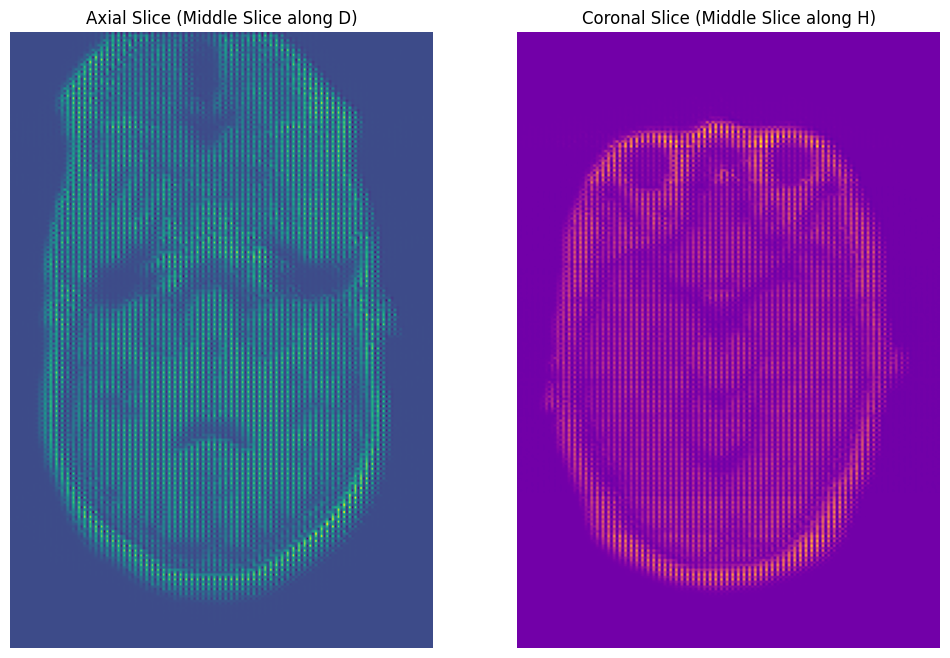

In [28]:

# Normalize and extract the middle slice
axial_middle_slice_index = axial_output.shape[2] // 2  # Middle slice along the D axis
coronal_middle_slice_index = coronal_output.shape[3] // 2  # Middle slice along the H axis

# Extract and normalize the slices
axial_slice = axial_output[0, 0, axial_middle_slice_index, :, :].cpu().detach().numpy()
coronal_slice = coronal_output[0, 0, :, coronal_middle_slice_index, :].cpu().detach().numpy()

# Normalize the slices to [0, 1] for better visualization
axial_slice = (axial_slice - np.min(axial_slice)) / (np.max(axial_slice) - np.min(axial_slice))
coronal_slice = (coronal_slice - np.min(coronal_slice)) / (np.max(coronal_slice) - np.min(coronal_slice))

print("Axial slice shape :",axial_slice.shape,"Coronal slice shape: ",coronal_slice.shape )
# Plot both axial and coronal slices
plt.figure(figsize=(12, 8))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_slice,aspect='auto')
plt.title("Axial Slice (Middle Slice along D)")
plt.axis('off')

# Plot the coronal slice
plt.subplot(1, 2, 2)
plt.imshow(coronal_slice,  cmap='plasma',aspect='auto')
plt.title("Coronal Slice (Middle Slice along H)")
plt.axis('off')

plt.show()

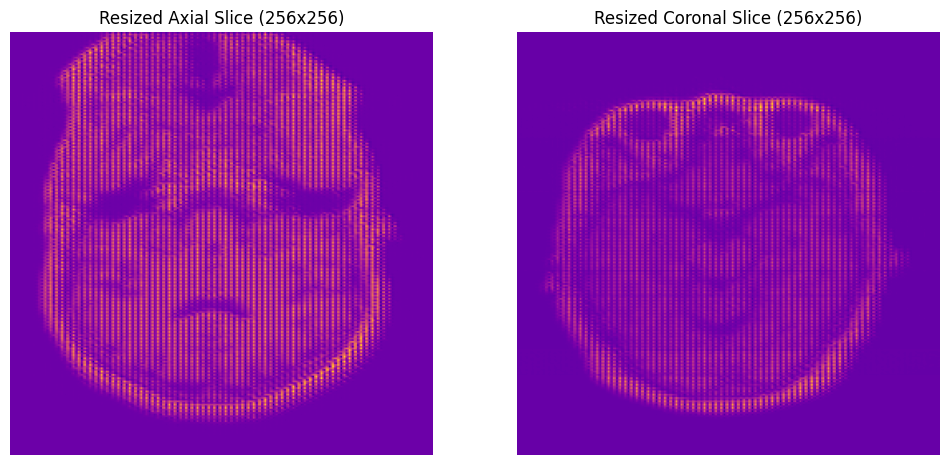

In [30]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt




# Convert to tensor
axial_slice_tensor = torch.tensor(axial_slice).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
coronal_slice_tensor = torch.tensor(coronal_slice).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

# Resize to (256, 256) using F.interpolate
axial_resized = F.interpolate(axial_slice_tensor, size=(256, 256), mode='bilinear', align_corners=False)
coronal_resized = F.interpolate(coronal_slice_tensor, size=(256, 256), mode='bilinear', align_corners=False)

# Convert back to numpy for visualization
axial_resized_np = axial_resized.squeeze().cpu().detach().numpy()
coronal_resized_np = coronal_resized.squeeze().cpu().detach().numpy()

# Plot the resized slices
plt.figure(figsize=(12, 8))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_resized_np, cmap='plasma')
plt.title("Resized Axial Slice (256x256)")
plt.axis('off')

# Plot the coronal slice
plt.subplot(1, 2, 2)
plt.imshow(coronal_resized_np, cmap='plasma')
plt.title("Resized Coronal Slice (256x256)")
plt.axis('off')

plt.show()


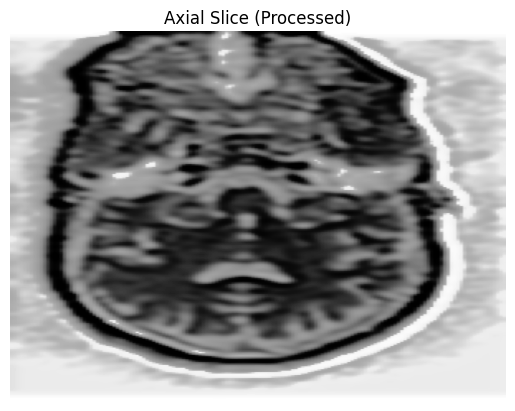

In [25]:
from scipy.ndimage import gaussian_filter
from skimage import exposure
import numpy as np

# Extract the middle slice
axial_slice = axial_output[0, 0, axial_middle_slice_index, :, :].cpu().detach().numpy()

# Step 1: Smooth the image (low-pass filter)
axial_slice_smoothed = gaussian_filter(axial_slice, sigma=2)

# Step 2: Normalize using robust percentiles
percentile_min = np.percentile(axial_slice_smoothed, 1)
percentile_max = np.percentile(axial_slice_smoothed, 99)
axial_slice_normalized = (axial_slice_smoothed - percentile_min) / (percentile_max - percentile_min)
axial_slice_normalized = np.clip(axial_slice_normalized, 0, 1)

# Step 3: Apply histogram equalization for better contrast
axial_slice_equalized = exposure.equalize_hist(axial_slice_normalized)

# Plot the result
plt.imshow(axial_slice_equalized, cmap='gray', aspect='auto')
plt.title("Axial Slice (Processed)")
plt.axis('off')
plt.show()


In [29]:
#for multiple image. 
print(axial_slice_equalized.shape)
print(axial_slice.shape)

(256, 150)
(256, 150)


In [41]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.0):
        super(GaussianBlur, self).__init__()
        
        # Store kernel size and sigma for later use
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.padding = kernel_size // 2  # Padding to maintain the input shape

        # Create the Gaussian kernel (will be used in the forward pass)
        self.register_buffer('kernel', self.create_gaussian_kernel())

    def create_gaussian_kernel(self):
        # Create a 2D Gaussian kernel using the formula
        ax = np.linspace(-(self.kernel_size // 2), self.kernel_size // 2, self.kernel_size)
        xx, yy = np.meshgrid(ax, ax)

        kernel = np.exp(-(xx**2 + yy**2) / (2.0 * self.sigma**2))
        kernel = kernel / np.sum(kernel)  # Normalize to ensure the sum is 1

        # Convert to a tensor
        return torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    def forward(self, x):
        # Apply Gaussian blur to the input tensor
        # We use the conv2d layer to perform the blur
        return F.conv2d(x, self.kernel, padding=self.padding, groups=x.shape[1])



# Initialize the GaussianBlur layer
gaussian_blur = GaussianBlur(kernel_size=5, sigma=1.0)


shape (256, 256)


/tmp/ipykernel_686394/1532132805.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axial_resized_tensor = torch.tensor(axial_resized, dtype=torch.float32)  # Shape: [1, 1, 256, 256]


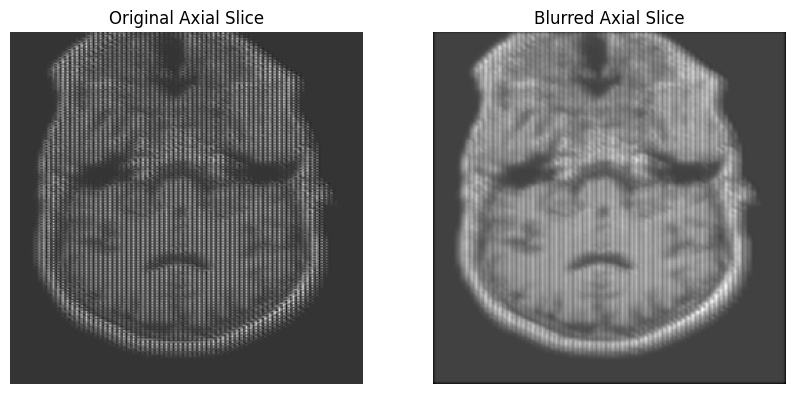

In [80]:
# Example: Assume you have a list of axial slices (e.g., axial_slices)
slices = [axial_resized, coronal_resized]  # List of axial slices

import torch
import numpy as np
import matplotlib.pyplot as plt


# Convert the numpy array to a PyTorch tensor
axial_resized_tensor = torch.tensor(axial_resized, dtype=torch.float32)  # Shape: [1, 1, 256, 256]

# Apply the Gaussian blur (assuming gaussian_blur is defined already)
blurred_axial_resized = gaussian_blur(axial_resized_tensor)  

# Convert the result to a numpy array for visualization
blurred_axial_resized_numpy = blurred_axial_resized.squeeze(0).squeeze(0).cpu().detach().numpy()


plt.figure(figsize=(10, 5))

# Original image (Squeeze to 2D for imshow)
axial_resized_2d = axial_resized_tensor.squeeze(0).squeeze(0).cpu().detach().numpy()  # Convert to 2D
print("shape",axial_resized_2d.shape)
plt.subplot(1, 2, 1)
plt.imshow(axial_resized_2d, cmap='gray')
plt.title("Original Axial Slice")
plt.axis('off')

# Blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_axial_resized_numpy, cmap='gray')
plt.title("Blurred Axial Slice")
plt.axis('off')

plt.show()




The CNN model, F, for correction had an input and output size of 256 × 256 × 1. The
architecture was a U-Net (Ronneberger et al., 2015) with five down-sampling levels. Each
down-sampling block contains two convolutional layers with symmetric padding and ReLU
activations (Glorot et al., 2011), Batch Normalization (Ioffe and Szegedy, 2014) and for
down-sampling to half the size, the model used Max Pooling layers. Each up-sampling
layer is constructed similarly using a bilinear upsampling layer, and an additional Gaussian
blur layer. The final output is constrained to values between 0.5 and 2

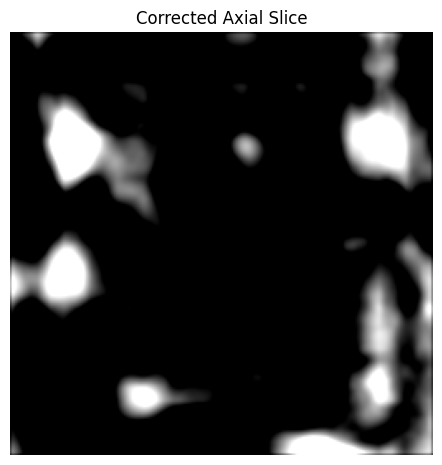

In [82]:

# Define U-Net architecture
class CustomUNet(nn.Module):
    def __init__(self):
        super(CustomUNet, self).__init__()
        
        # Define the down-sampling path (Encoder)
        self.down1 = self.conv_block(1, 64)  # (1, 64)
        self.down2 = self.conv_block(64, 128)  # (64, 128)
        self.down3 = self.conv_block(128, 256)  # (128, 256)
        self.down4 = self.conv_block(256, 512)  # (256, 512)
        self.down5 = self.conv_block(512, 1024)  # (512, 1024)

        # Define the up-sampling path (Decoder)
        self.up5 = self.deconv_block(1024, 512)  # (1024, 512)
        self.up4 = self.deconv_block(512, 256)  # (512, 256)
        self.up3 = self.deconv_block(256, 128)  # (256, 128)
        self.up2 = self.deconv_block(128, 64)  # (128, 64)
        self.up1 = self.deconv_block(64, 1)  # (64, 1)

        # Gaussian Blur Layer
        self.gaussian_blur = GaussianBlur(kernel_size=5, sigma=1.0)

    def conv_block(self, in_channels, out_channels):
        # A block of convolutional layers with BatchNorm and ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling to downsample
        )

    def deconv_block(self, in_channels, out_channels):
            # A block of up-convolutions with Bilinear Upsampling using F.interpolate
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),  # 1x1 convolution to match channels
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
    )

    def forward(self, x):
        # Down-sampling (Encoder)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        # Up-sampling (Decoder)
        x = self.up5(x5)
        x = self.up4(x)
        x = self.up3(x)
        x = self.up2(x)
        x = self.up1(x)

        # Apply Gaussian blur after up-sampling
        x = self.gaussian_blur(x)

        # Clamp the output to be between 0.5 and 2
        return torch.clamp(x, min=0.5, max=2.0)


#just for test the unet and gussian blur are working correctly. 


# Ensure both the model and input tensor are on the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = CustomUNet().to(device)
axial_resized_tensor = axial_resized_tensor.to(device).float()  

with torch.no_grad():
    axial_output = model(axial_resized_tensor)

# Convert to numpy for visualization
axial_output_np = axial_output.squeeze().cpu().detach().numpy()

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(axial_output_np, cmap='gray')
plt.title("Corrected Axial Slice")
plt.axis('off')
plt.show()


In [83]:
def output_range(x):
    rng = 1
    x = torch.where(x > -rng, x, -rng * torch.ones_like(x))
    x = torch.where(x < rng, x, rng * torch.ones_like(x))
    return x
#input is torch.tensor 

# PSNR function to evaluate image quality
def psnr(y_true, y_pred):

    if isinstance(y_true, np.ndarray):
        y_true = torch.tensor(y_true)
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.tensor(y_pred)

    mse = torch.mean((y_true - y_pred) ** 2)
    PIXEL_MAX = 1.0  # original is 255 but (gt)Normalized image pixel range [0, 1]
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))


def implicit_relation(tensor):
    a = tensor[0]
    b = tensor[1]
    # Ensure both tensors are on the same device
    if a.device != b.device:
        b = b.to(a.device)
    c = a - b
    return c



def implicit_correction(tensor):

    if isinstance(tensor, np.ndarray):#ensure that is tensor.
        tensor = torch.tensor(tensor)

    c = tensor 
    
    # Compute the minimum along axes (1, 2, 3)
    c_min = torch.min(c, dim=1, keepdim=True).values
    c = c + c_min  
    
    # Compute the maximum along axes (1, 2, 3)
    c_max = torch.max(c, dim=1, keepdim=True).values
    c = c / (c_max + 1e-8)  # Adding epsilon for numerical stability
    
    return c